In [1]:
from bs4 import BeautifulSoup
from urllib2 import urlopen, HTTPError, URLError
from urlparse import urlparse, urljoin
import os.path, errno
import shutil
import subprocess32 as subprocess
from concurrent.futures import *
from itertools import islice

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
cd ~/MEGA/eScienceWork/projects/OOIVideos/OOIVideos

/home/val/MEGA/eScienceWork/projects/OOIVideos/OOIVideos


In [4]:
# gd_url = 'https://drive.google.com/folderview?id=0Bxkqjvq_AAi_bVU0bDFocFl0SG8&usp=sharing'

In [5]:
import imageio

In [6]:
filename = 'opendap_hyrax_large_format_RS03ASHS-PN03B-06-CAMHDA301_2016_01_01_CAMHDA301-20160101T210000Z.mp4'

<IPython.core.display.Javascript object>


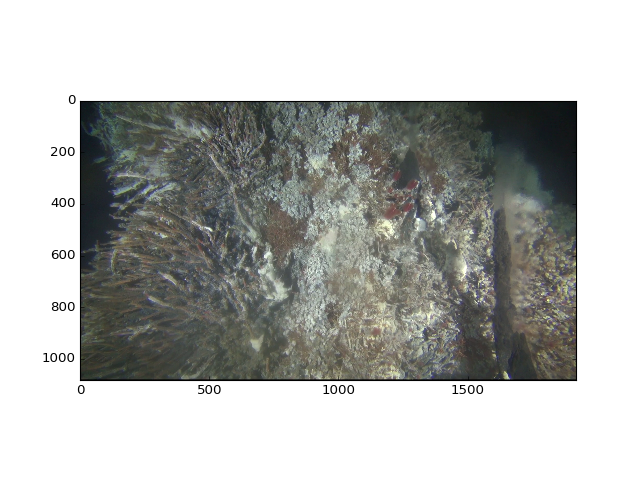

In [7]:
vid = imageio.get_reader(filename,  'ffmpeg')
nums = [2760,8160,13200]
for num in nums:
    image = vid.get_data(num)
    plt.imshow(image)
    plt.show()
    

In [8]:
len(vid)

25200

In [9]:
# Frames per second
25200/(14*60)

30

In [10]:
# 7:20
(7*60+20)*30

13200

In [11]:
# 4:32
(4*60+32)*30

8160

In [12]:
#1:42
(1*60+32)*30

2760

In [13]:
np.arange(0,24,3)

array([ 0,  3,  6,  9, 12, 15, 18, 21])

In [14]:
date = '2016_01_01'
import imageio
import time

### Processing the boundary at 4:32

<IPython.core.display.Javascript object>


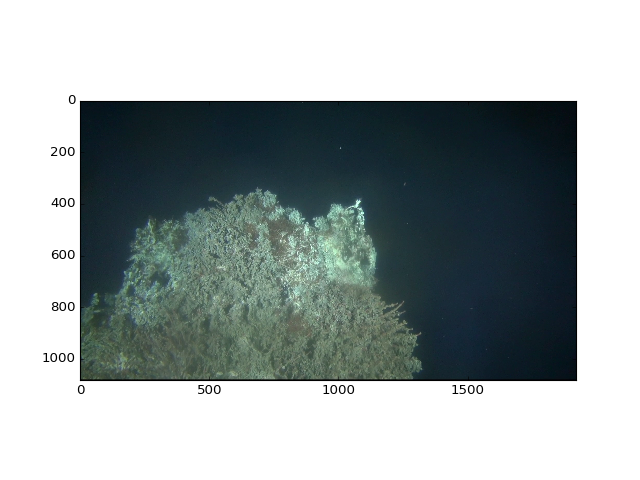

In [15]:
plt.figure()
fig = plt.gcf()
fig.show()
fig.canvas.draw()


frames_bdry = []
for i in np.arange(0,24,3):
    if i != 15:
        filename = 'opendap_hyrax_large_format_RS03ASHS-PN03B-06-CAMHDA301_2016_01_01_CAMHDA301-20160101T'+str(i).zfill(2)+'0000Z.mp4'
        vid = imageio.get_reader(filename,  'ffmpeg')
        # nums = [2760,8160,13200]
        num = 13200
        num = 8160
        #for num in nums:
        image = vid.get_data(num)
        frames_bdry.append(image)

    plt.imshow(image)
    fig.canvas.draw()
    
    
 

In [17]:
# extract the dimensions
print('Number of frames: '+ str(len(frames_bdry)))
print('Image size: '+ str(frames_bdry[0].shape))
nofFrames = len(frames_bdry)
dim1  = frames_bdry[0].shape[0]
dim2 = frames_bdry[0].shape[1]

Number of frames: 7
Image size: (1080, 1920, 3)


##### There is jitter! 
Seems like the camera does not point at exactly the same position once it returns to the same location after 3 hours. We need to adjust for it if we are interested in the growth of the structure.  

Without resorting to fancier methods from OpenCV, we can use the register_translation function from scikit-image.

In [18]:
from skimage.feature import register_translation
help(register_translation)

Help on function register_translation in module skimage.feature.register_translation:

register_translation(src_image, target_image, upsample_factor=1, space='real')
    Efficient subpixel image translation registration by cross-correlation.
    
    This code gives the same precision as the FFT upsampled cross-correlation
    in a fraction of the computation time and with reduced memory requirements.
    It obtains an initial estimate of the cross-correlation peak by an FFT and
    then refines the shift estimation by upsampling the DFT only in a small
    neighborhood of that estimate by means of a matrix-multiply DFT.
    
    Parameters
    ----------
    src_image : ndarray
        Reference image.
    target_image : ndarray
        Image to register.  Must be same dimensionality as ``src_image``.
    upsample_factor : int, optional
        Upsampling factor. Images will be registered to within
        ``1 / upsample_factor`` of a pixel. For example
        ``upsample_factor == 20

This function returns only the shifts, so we need to define additional functions to translate the images based on those shifts.

In [20]:
# a function which translates the image based on a shift (it also restores the original dimensions by padding with zeros)
def translate(frame, shift):
    shift = shift.astype('int')
  
    # creating padding
    if shift[0]>=0:
        a = (0,shift[0])
        frame_shifted = frame[shift[0]:,:,:]
    else:
        a = (np.abs(shift[0]),0)
        frame_shifted = frame[:shift[0],:,:]
    if shift[1]>=0:
        b = (0,shift[1])
        frame_shifted = frame_shifted[:,shift[1]:,:]
    else:
        b = (np.abs(shift[1]),0)
        frame_shifted = frame_shifted[:,:shift[1],:]
    res = np.lib.pad(frame_shifted,(a,b,(0,0)),mode = 'reflect') # explore why mode = 'edge' is not acting as expected
    return(res)

In [21]:
# a function registers a list of frames to a template by
# 1) first extracting the shift through register_translation
# 2) next shifts this image using translate

def register_frames(frames, template):
    frames_registered = []
    for frame in frames:
        shift = register_translation(frame, template)
        frames_registered.append(translate(frame,shift[0]))
    return(frames_registered)

We will register all the frames to the first frame:

In [22]:
frames_registered = register_frames(frames_bdry[1:],frames_bdry[0])

In [23]:
from skimage import filters

<IPython.core.display.Javascript object>


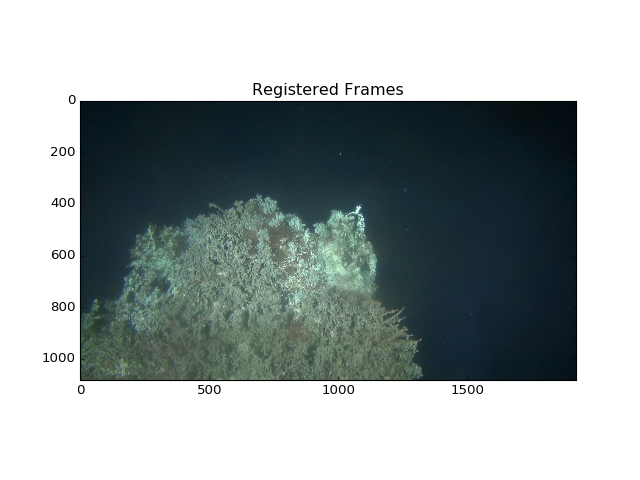

In [24]:
fig = plt.figure()
fig.show()
fig.canvas.draw()
plt.title('Registered Frames')
for frame in frames_registered:
    plt.imshow(frame)
    fig.show()
    fig.canvas.draw()

In [25]:
(frames_registered[0]).shape

(1080, 1920, 3)

In [26]:
import imageio

In [176]:
writer = imageio.get_writer('Registered_Video.mp4', 'ffmpeg',fps=1)

for im in frames_registered:
    writer.append_data(im)
writer.close()

In [180]:
writer = imageio.get_writer('Raw_Video.mp4', 'ffmpeg',fps=1)

for im in frames_bdry:
    writer.append_data(im)
writer.close()

In [216]:
writer = imageio.get_writer('Smoke.mp4', 'ffmpeg',fps=1)

for im in frames_13200:
    writer.append_data(im)
writer.close()

##### Let's now look at the boundaries. Here is some rough extraction based on simple tresholding:

In [113]:
# from skimage import feature
# edges = feature.canny(frames[0][:,:,0], sigma=3)
from skimage.segmentation import find_boundaries


<IPython.core.display.Javascript object>


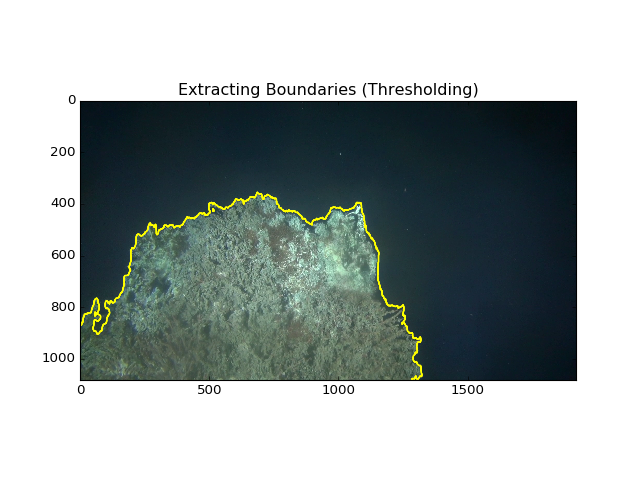

In [189]:
plt.figure()
fig = plt.gcf()
fig.show()
fig.canvas.draw()

for frame in frames_registered:
    frame_filtered = filters.gaussian(frame[:,:,0],sigma = 10, multichannel = True)
    binary = frame_filtered*255<50
    # plt.imshow(edges,cmap = 'gray')
    bdry = find_boundaries(binary, connectivity = 5)
    plt.clf()
    plt.imshow(frame)
    plt.title('Extracting Boundaries (Thresholding)')
    plt.contour(binary,origin = 'lower',colors = 'yellow')
    #plt.imshow((1 - bdry)*frame[:,:,0], cmap = 'gray')
    fig.show()
    fig.canvas.draw()
    

In [26]:
# np.max(frames_bdry[3][0,:,2]) -- understand edges???

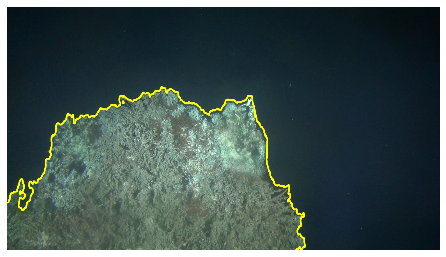

In [244]:
plt.figure(frameon=False)
fig = plt.gcf()
fig.show()
fig.canvas.draw()

vid = imageio.get_writer('BoundaryExtraction.mp4',fps = 1)

for frame in frames_registered:
    frame_filtered = filters.gaussian(frame[:,:,0],sigma = 10, multichannel = True)
    binary = frame_filtered*255<50
    # plt.imshow(edges,cmap = 'gray')
    bdry = find_boundaries(binary, connectivity = 5)
    plt.clf()
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(frame)
    ax.contour(binary,origin = 'lower',colors = 'yellow')
    #plt.imshow((1 - bdry)*frame[:,:,0], cmap = 'gray')
    ax.set_frame_on(False)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    fig.savefig('temp.jpg',bbox_inches='tight', pad_inches=0, transparent = True)
    
    plt.axis('off')
    vid.append_data(imageio.imread('temp.jpg'))
    
    
    fig.show()
    fig.canvas.draw()

In [246]:
vid.close()

In [27]:
# Active contour segmentation: it seems to bias closed contours

In [28]:
# from skimage.segmentation import active_contour 

In [29]:
# initialization
# s = np.linspace(0, 2*np.pi,100)
# init = 500*np.array([np.cos(s), np.sin(s)]).T+1000

In [30]:
# snake = active_contour(binary, init, w_edge=0, w_line=1) 

In [31]:
# plt.figure()
# plt.plot(snake[:,0],snake[:,1])
# plt.imshow(binary)
# plt.show()

### Processing slices at 7:20

<IPython.core.display.Javascript object>


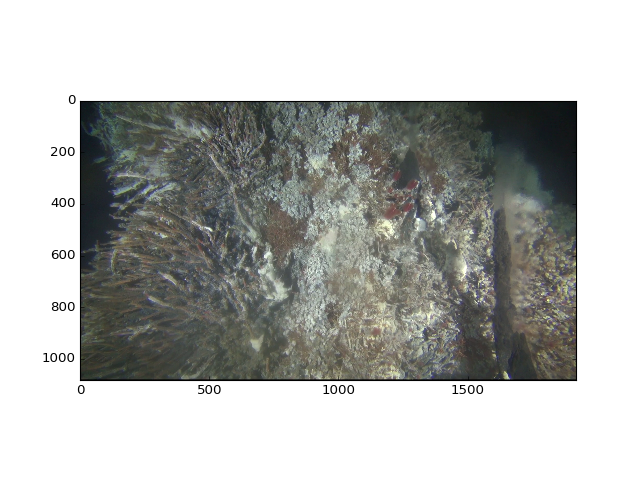

In [30]:
plt.figure()
fig = plt.gcf()
fig.show()
fig.canvas.draw()


frames_13200 = []
for i in np.arange(0,24,3):
    if i != 15:
        filename = 'opendap_hyrax_large_format_RS03ASHS-PN03B-06-CAMHDA301_2016_01_01_CAMHDA301-20160101T'+str(i).zfill(2)+'0000Z.mp4'
        vid = imageio.get_reader(filename,  'ffmpeg')
        # nums = [2760,8160,13200]
        num = 13200
        image = vid.get_data(num)
        frames_13200.append(image)

    plt.imshow(image)
    fig.canvas.draw()
    
    

In [31]:
nofFrames = 6

In [32]:
video = np.array(frames_registered)

In [33]:
video.shape

(6, 1080, 1920, 3)

### PCA Decomposition

In [58]:
from sklearn.decomposition import PCA, FastICA, NMF

In [59]:
pca = PCA(n_components = nofFrames)

In [60]:
pca.fit(np.reshape(video[:,:,:,0],(nofFrames,dim1*dim2*1)))

PCA(copy=True, n_components=6, whiten=False)

In [61]:
pca.components_.shape

(6, 2073600)

In [62]:
modes = np.reshape(pca.components_,(nofFrames,dim1,dim2,1))

In [63]:
pca.components_.shape

(6, 2073600)

In [64]:
modes.shape

(6, 1080, 1920, 1)

In [65]:
np.max(modes)

0.23001788275131499

In [66]:
# plt.imshow((modes[0,:,:,2]+0.2)*255,cmap = 'gray')

In [67]:
# np.min((modes[m,:,:,0]-mmin)/(mmax - mmin)*255)

In [68]:
plt.imshow(modes[1,:,:,0],cmap = 'gray')

In [70]:
%matplotlib inline

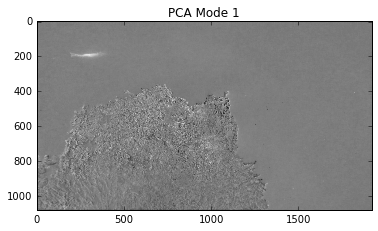

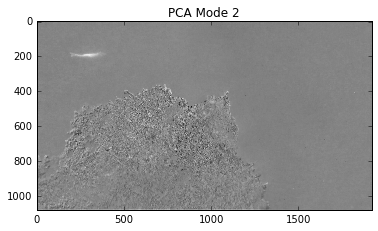

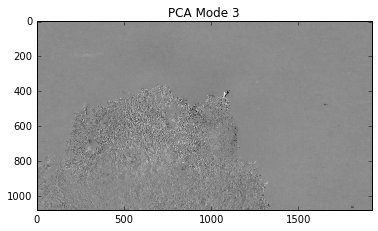

In [77]:
nofModes = 3 #number of modes to display 
for m in range(nofModes): #range(modes.shape[0]):
    plt.figure()
    mmin = np.min(modes[m,:,:,0])
    mmax = np.max(modes[m,:,:,0])
    # plt.imshow(color.rgb2grey(modes[m,:,:,:]),cmap = 'gray')
    plt.imshow((modes[m,:,:,0]-mmin)/(mmax - mmin)*255,cmap = 'gray')
    #plt.imshow(modes[m,:,:,0],cmap = 'gray')
    plt.title('PCA Mode '+  str(m+1))

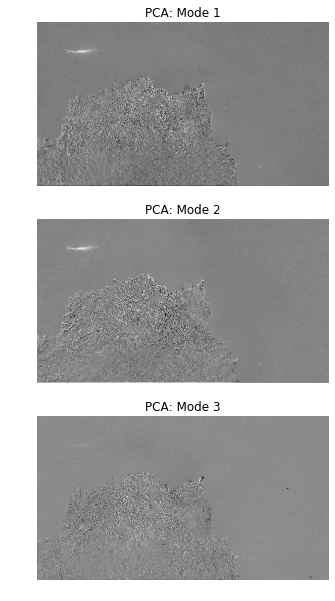

In [82]:
plt.figure(figsize = (10,10))
for m in range(nofModes):#rangeo(modes.shape[0]):
    plt.subplot(nofModes, 1, m+1)
    plt.imshow(modes[m,:,:,0],cmap = 'gray')
    plt.axis('off')
    plt.title('PCA: Mode '+  str(m+1))
plt.savefig('Boundary_PCA.png')

In [75]:
np.min(modes)

-0.96691158289411927

In [76]:
np.min(modes)

-0.96691158289411927

In [66]:
np.min(modes[6,:])

-0.97615517422269027

In [69]:
np.max(modes[6,:,:,:])

0.20109855668960422

In [70]:
np.max(modes[6])

0.20109855668960422

#### ICA Decomposition

/home/val/anaconda3/envs/OOI/lib/python2.7/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


<IPython.core.display.Javascript object>


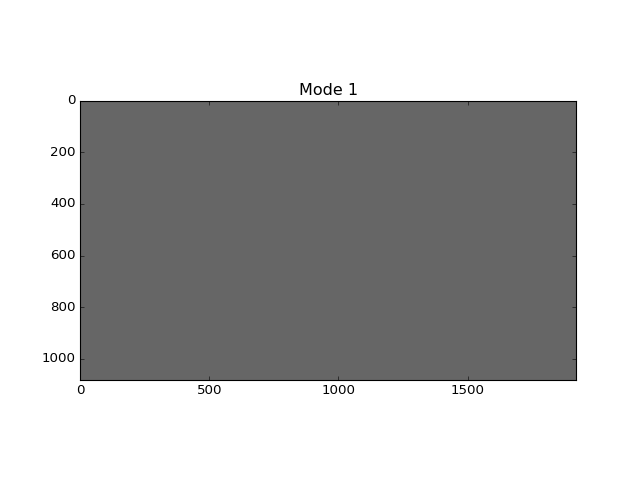

<IPython.core.display.Javascript object>


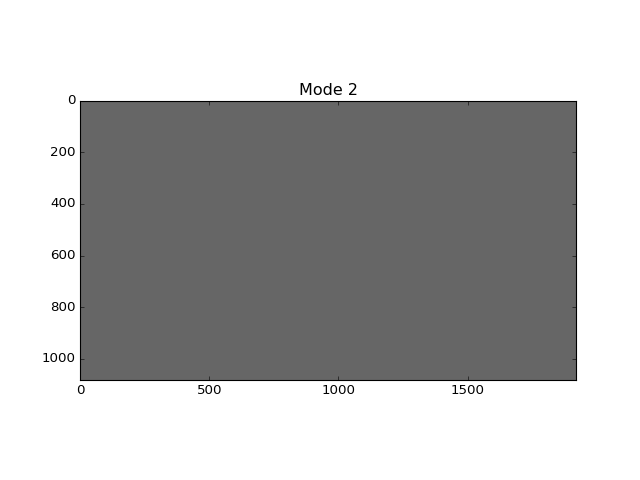

<IPython.core.display.Javascript object>


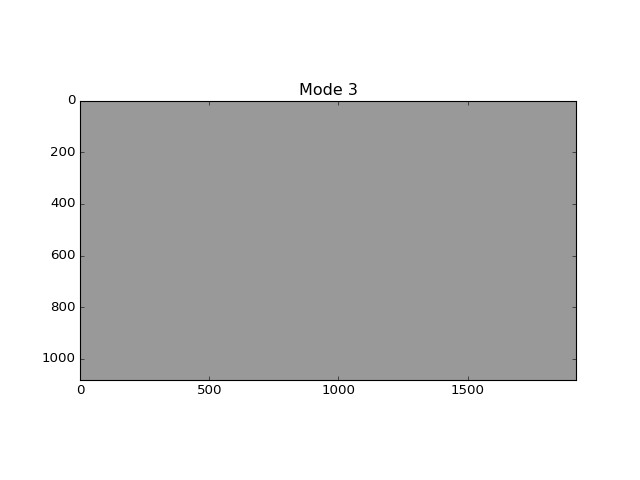

<IPython.core.display.Javascript object>


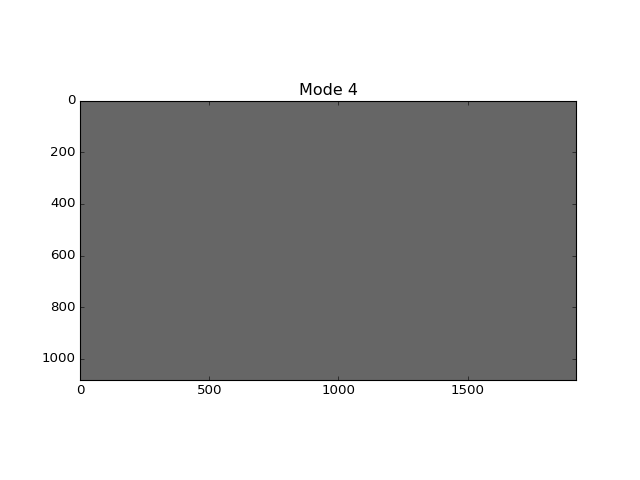

<IPython.core.display.Javascript object>


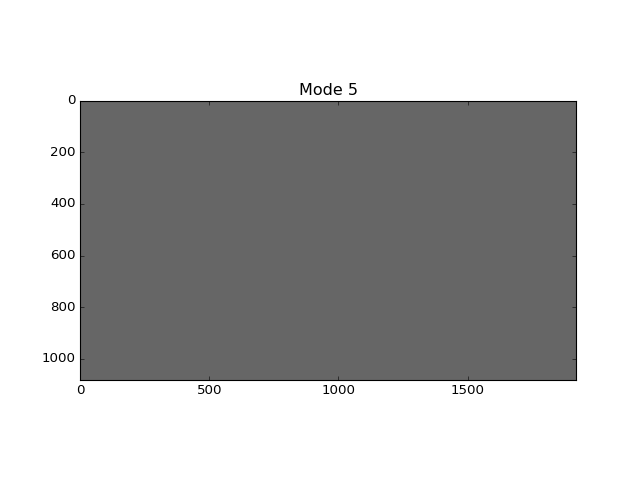

<IPython.core.display.Javascript object>


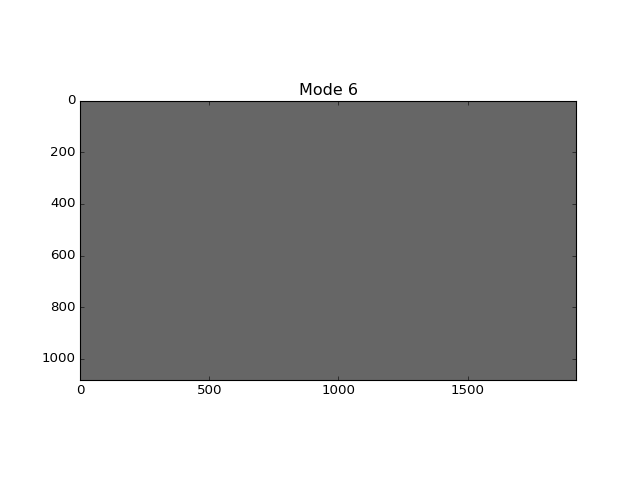

<IPython.core.display.Javascript object>


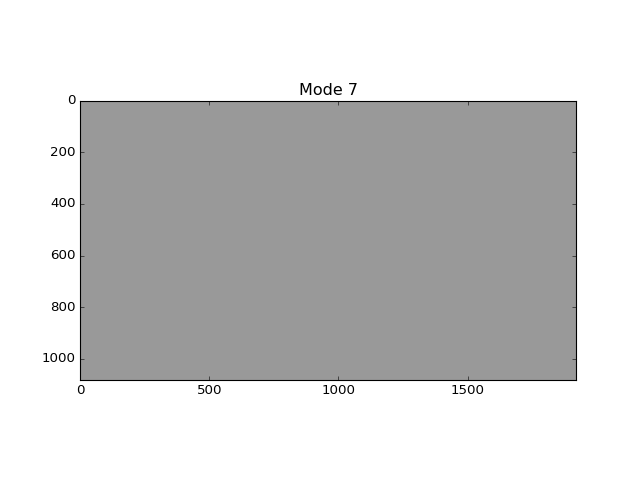

In [86]:
from sklearn.decomposition import FastICA
ica = (n_components = nofFrames)
ica.fit(np.reshape(video[:,:,:,0],(nofFrames,dim1*dim2*1)))
modes = np.reshape(ica.components_,(nofFrames,dim1,dim2,1))

for m in range(modes.shape[0]):
    plt.figure()
    plt.imshow(modes[m,:,:,0],cmap = 'gray')
    plt.title('Mode '+  str(m+1))

#### NMF Decomposition

<IPython.core.display.Javascript object>


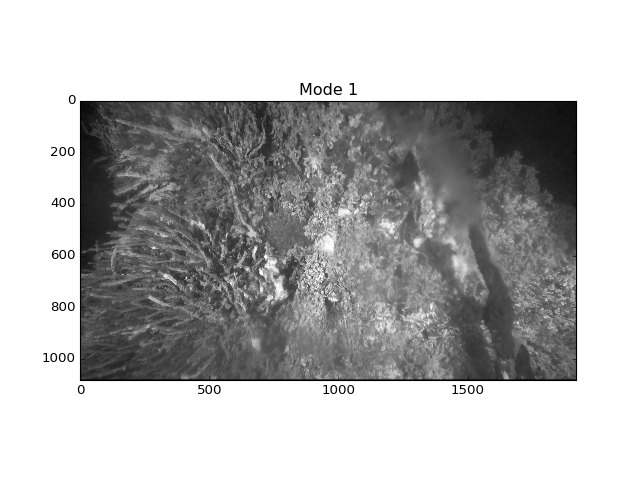

/home/val/anaconda3/envs/OOI/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


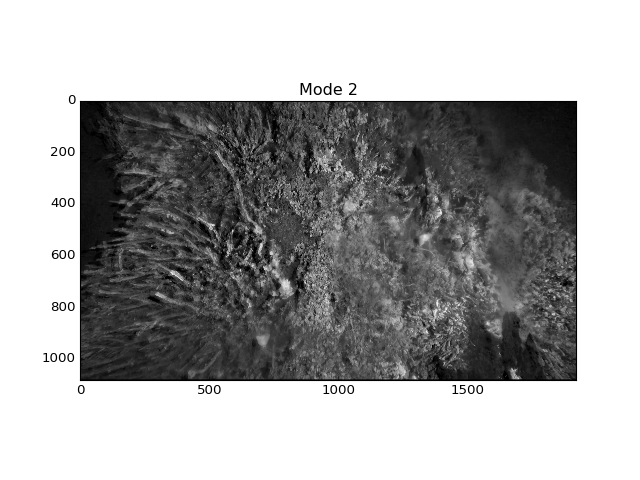

<IPython.core.display.Javascript object>


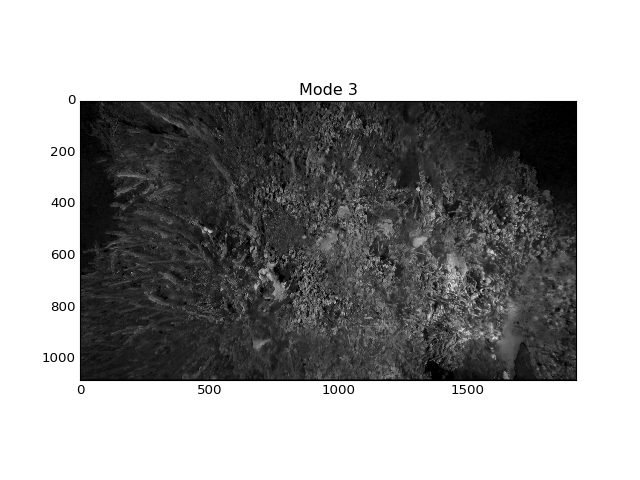

<IPython.core.display.Javascript object>


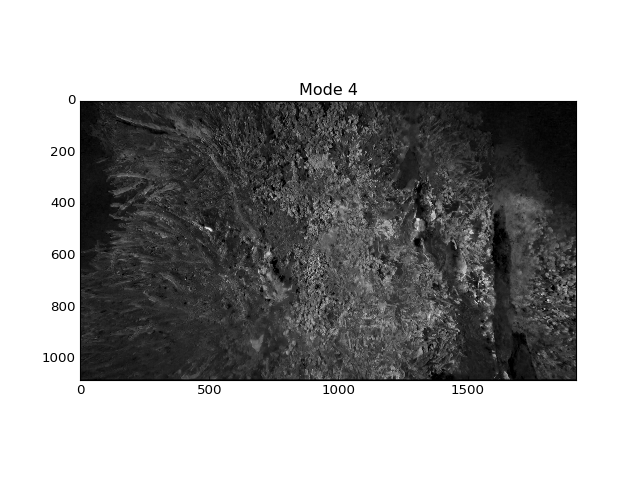

<IPython.core.display.Javascript object>


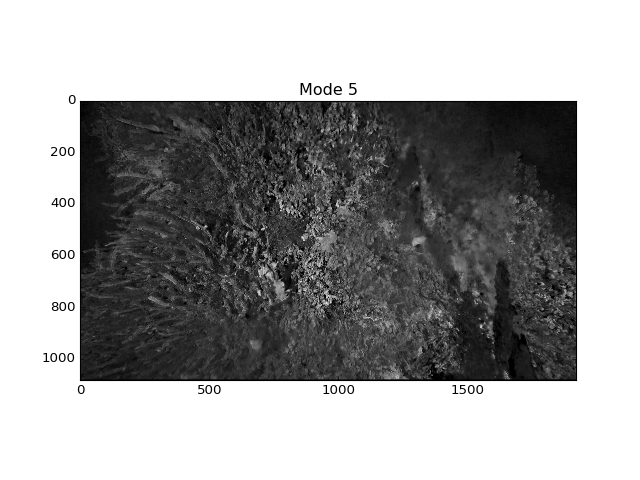

<IPython.core.display.Javascript object>


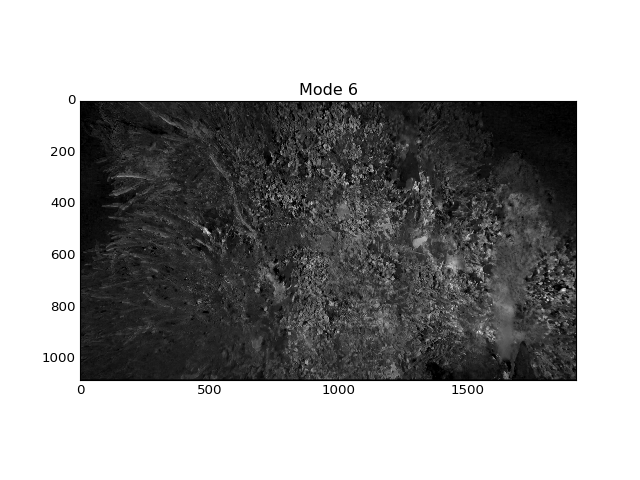

<IPython.core.display.Javascript object>


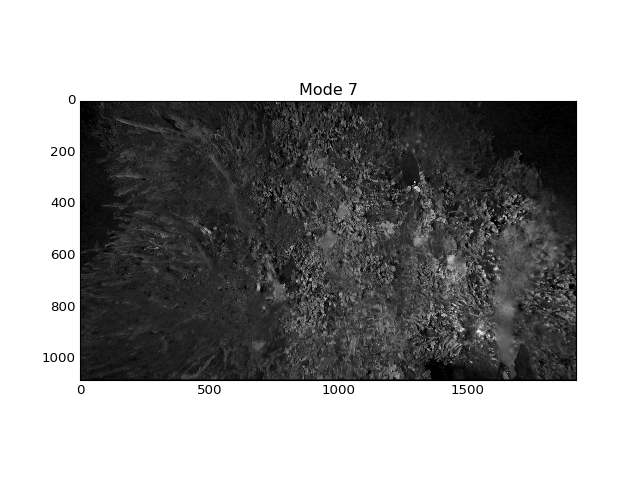

In [85]:
from sklearn.decomposition import NMF
nmf = NMF(n_components = nofFrames)
nmf.fit(np.reshape(video[:,:,:,0],(nofFrames,dim1*dim2*1)))
modes = np.reshape(nmf.components_,(nofFrames,dim1,dim2,1))

for m in range(modes.shape[0]):
    plt.figure()
    plt.imshow(modes[m,:,:,0],cmap = 'gray')
    plt.title('Mode '+  str(m+1))

#### OpenCV test

In [8]:
import cv2

In [9]:
#### Need to link to ffmpeg!!!!!

<module 'cv2' from '/home/val/anaconda3/envs/OOI/lib/python2.7/site-packages/cv2.so'>

In [15]:
cap = cv2.VideoCapture("/home/val/MEGA/eScienceWork/projects/OOIVideos/OOIVideos/opendap_hyrax_large_format_RS03ASHS-PN03B-06-CAMHDA301_2016_01_01_CAMHDA301-20160101T210000Z.mp4")
cap.grab()

False

In [4]:
cap = cv2.VideoCapture(0)

In [16]:
print(cap.grab())
success,image = cap.read()
print(success)

False
False


In [6]:
#video.open()
video = []
success = 1
while success:
    success, image = cap.read()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    video.append(gray)
    #cv2.imshow('frame',gray)

error: -------src-dir-------/opencv-2.4.10/modules/imgproc/src/color.cpp:3739: error: (-215) scn == 3 || scn == 4 in function cvtColor


In [ ]:
len(video)

In [ ]:
success, image = cap.read()

In [ ]:
print(success)

In [ ]:
cap.isOpened()

In [ ]:
plt.figure()
plt.imshow(gray)
plt.show()

In [ ]:
print(len(values))
# plt.figure(figsize = (16,6))
plt.plot(np.array(values[1500:1880]))
plt.show()

In [ ]:
# plt.imshow(frames[1250])

plt.figure()
fig = plt.gcf()
fig.show()
fig.canvas.draw()

for i in range(200):
    plt.imshow(vid.get_data(1500+i))
    plt.title(str(1500+i))
    fig.show()
    fig.canvas.draw()
    
    #plt.pause(1)


In [ ]:
# for the flat regions: detect what is moving in the flat regions

# 1) create a mask based on a threshold of values
idx = (values>10000)
# for each chunk of ones: apply 

In [ ]:
len(vid)

In [ ]:
video = np.aray(frames)
res = np.sum(np.abs(video[1:,:,:,:] -video[:video.shape[0]-1,:,:,:]))